## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [109]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # we can try this as a resampling technique to address class imbalance

import tensorflow
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import classification_report, confusion_matrix



ModuleNotFoundError: No module named 'imblearn'


The following command must be run outside of the IPython shell:

    $ pip install -U imbalanced-learn

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

In [4]:
len(train_data)

84534

In [5]:
train_data['purchase'].value_counts() # note the huge imbalance, which will affect neural network

0    83494
1     1040
Name: purchase, dtype: int64

In [6]:
# Check the length of the control and treatment groups

In [7]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [8]:
# Here is probably the place to bring in the historgrams of V1-V7

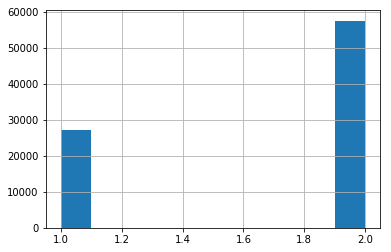

In [9]:
train_data['V4'].hist()

In [10]:
# Is the 'purchase' var significantly different in the two groups?

In [11]:
control_group = train_data[train_data['Promotion']=='No']

In [12]:
treatment_group = train_data[train_data['Promotion']=='Yes']

In [13]:
treatment_group['purchase'].value_counts()

0    41643
1      721
Name: purchase, dtype: int64

In [14]:
n_cont = len(control_group)

In [15]:
n_treat = len(treatment_group)

In [16]:
n_obs = len(train_data)

In [17]:
purch_control = (len(control_group[control_group['purchase']==1])) / n_cont

In [18]:
purch_control

0.007564619397676073

In [19]:
purch_treat = (len(treatment_group[treatment_group['purchase']==1])) / n_treat

In [20]:
purch_treat # suggests a really unoptimised promotion strategy!

0.017019167217448776

In [21]:
# Test invariant metric - I can see they're basically the same but let's practice some of the course material

In [22]:
p = 0.5

In [23]:
sd = np.sqrt(p * (1-p)* n_obs)

In [24]:
z = ((n_cont + 0.5) - p*n_obs) / sd

In [25]:
p_stat = 2*sp.stats.norm.cdf(z)

In [26]:
p_stat # absolutely nowhere near rejecting the null hypothesis

0.50681406854190458

In [27]:
# Test Var metric

In [28]:
P = train_data['purchase'].mean() # This is not drawn from a priori assumptions but from the data

In [29]:
SE = np.sqrt(P * (1-P) *( 1/n_cont + 1/n_treat))

In [30]:
Z = (purch_treat - purch_control) / SE # again not done a priori

In [31]:
P_var = 1 - sp.stats.norm.cdf(Z)

In [32]:
P_var # These are two very distinct distributions

0.0

In [33]:
# Was the treatment successful?

In [34]:
# Incremental Response Rate  - change in uptake

In [35]:
purch_treat - purch_control # so the promotion increased the uptake proportion by almost a 1 percent
# Remember that purch_treat and purch_control are already divided by the group size

0.009454547819772702

In [36]:
# Net Incremental Revenue - change in $$$

In [37]:
n_treat_purchasers = len(treatment_group[treatment_group['purchase']==1])

In [38]:
n_treat_purchasers

721

In [39]:
n_control_purchasers = len(control_group[control_group['purchase']==1])

In [40]:
treatment_cost = 0.15

In [41]:
NIR = ((n_treat_purchasers*10) - (n_treat_purchasers*treatment_cost)) - (n_control_purchasers*10)

In [42]:
NIR # Additional revenue of $3911. Factor in costs from employee time spent on designing promo, making materials,
# setting up data collection framework, governance etc, this probably isn't worth it

3911.8500000000004

In [43]:
# Look at relationships between variables

In [44]:
correlation_data = train_data.drop(['ID', 'Promotion'], axis=1)

In [45]:
correlations = correlation_data.corr()
correlations

,purchase,V1,V2,V3,V4,V5,V6,V7
purchase,1.000000,-0.004906,-0.001694,-0.006395,0.032245,0.007814,-0.001538,-0.001117
V1,-0.004906,1.000000,-0.001564,0.003995,0.002568,-0.001196,-0.003672,0.001436
V2,-0.001694,-0.001564,1.000000,0.001165,0.002848,-0.001046,-0.004156,-0.002293
V3,-0.006395,0.003995,0.001165,1.000000,0.003753,-0.001736,0.004464,0.001135
V4,0.032245,0.002568,0.002848,0.003753,1.000000,0.003161,0.002552,-0.003176
V5,0.007814,-0.001196,-0.001046,-0.001736,0.003161,1.000000,-0.003043,0.003571
V6,-0.001538,-0.003672,-0.004156,0.004464,0.002552,-0.003043,1.000000,-0.001398
V7,-0.001117,0.001436,-0.002293,0.001135,-0.003176,0.003571,-0.001398,1.000000


### What does a regression tell us in terms of effects?

In [46]:
Y = train_data['purchase']

In [47]:
X = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

In [48]:
reg_model = sm.OLS(Y, X)

In [49]:
results = reg_model.fit()

In [50]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     164.8
Date:                Mon, 27 May 2024   Prob (F-statistic):          4.11e-243
Time:                        16:42:51   Log-Likelihood:                 66512.
No. Observations:               84534   AIC:                        -1.330e+05
Df Residuals:                   84527   BIC:                        -1.329e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
V1            -0.0006      0.000     -1.466      0.1

In [51]:
# Prep for ANN and creating predictions

In [74]:
# create train and test data - do we actually need to do this, given that we have a test data csv

In [75]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

In [76]:
len(x_test)

16907

In [77]:
len(y_test)

16907

In [78]:
# Move the normalisation steps here

In [79]:
scaler= MinMaxScaler()

In [80]:
x_train_scaled= scaler.fit_transform(x_train)

In [81]:
x_test_scaled = scaler.transform(x_test)

In [82]:
# This gives us an idea of which variables might be driving a consumer's decision to buy the product or not
# We can use this information to refine the neural net potentially

In [83]:
# we will want to compare predicted with observed - test data has observations for promo and purchase. Will also want to compare IRR and NIR

In [84]:
model = Sequential()

In [85]:
model.add(Dense(7, input_dim=7, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [86]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
model.fit(x_train_scaled, y_train, epochs = 20, batch_size=64, validation_split=0.2)

Train on 54101 samples, validate on 13526 samples
Epoch 1/20
54101/54101 [==============================] - 3s 56us/step - loss: 0.1320 - acc: 0.9816 - val_loss: 0.0692 - val_acc: 0.9884
Epoch 2/20
54101/54101 [==============================] - 3s 56us/step - loss: 0.0717 - acc: 0.9876 - val_loss: 0.0663 - val_acc: 0.9884
Epoch 3/20
54101/54101 [==============================] - 3s 56us/step - loss: 0.0694 - acc: 0.9876 - val_loss: 0.0649 - val_acc: 0.9884
Epoch 4/20
54101/54101 [==============================] - 3s 59us/step - loss: 0.0679 - acc: 0.9876 - val_loss: 0.0638 - val_acc: 0.9884
Epoch 5/20
54101/54101 [==============================] - 3s 55us/step - loss: 0.0672 - acc: 0.9876 - val_loss: 0.0636 - val_acc: 0.9884
Epoch 6/20
54101/54101 [==============================] - 3s 57us/step - loss: 0.0669 - acc: 0.9876 - val_loss: 0.0634 - val_acc: 0.9884
Epoch 7/20
54101/54101 [==============================] - 3s 58us/step - loss: 0.0665 - acc: 0.9876 - val_loss: 0.0634 - val_acc

In [ ]:
#Can see that val accuracy hasn't really changed at all, so super early convergence

In [88]:
preds = model.predict(x_test_scaled)
preds = np.round(preds).astype(int)   


In [89]:
print(confusion_matrix(y_test, preds)) # So this has predicted everything as positive

[[16695     0]
 [  212     0]]


In [ ]:
# Lets try one of the weighting techniques for addressing the class imbalance - if this doesn't work can try resampling

In [90]:
len(preds)

16907

In [91]:
len(y_test)

16907

In [92]:
len(x_test_scaled)

16907

In [105]:
weighted_model = Sequential()

In [106]:
weighted_model.add(Dense(50, input_dim=7, activation = 'relu'))
weighted_model.add(Dense(35, activation = 'relu'))
weighted_model.add(Dense(35, activation = 'relu'))
weighted_model.add(Dense(1, activation = 'sigmoid'))

In [107]:
weighted_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [108]:
weights_grid = {0: 0.15, 1: 10}
weighted_model.fit(x_train_scaled, y_train, epochs=30, batch_size=64, validation_split=0.2, class_weight=weights_grid)

Train on 54101 samples, validate on 13526 samples
Epoch 1/30
54101/54101 [==============================] - 4s 71us/step - loss: 0.1860 - acc: 0.6961 - val_loss: 0.1829 - val_acc: 0.4004
Epoch 2/30
54101/54101 [==============================] - 3s 64us/step - loss: 0.1845 - acc: 0.6244 - val_loss: 0.1844 - val_acc: 0.6793
Epoch 3/30
54101/54101 [==============================] - 4s 67us/step - loss: 0.1844 - acc: 0.6285 - val_loss: 0.1829 - val_acc: 0.9728
Epoch 4/30
54101/54101 [==============================] - 4s 68us/step - loss: 0.1842 - acc: 0.6678 - val_loss: 0.1837 - val_acc: 0.6825
Epoch 5/30
54101/54101 [==============================] - 4s 66us/step - loss: 0.1840 - acc: 0.6867 - val_loss: 0.1820 - val_acc: 0.6510
Epoch 6/30
54101/54101 [==============================] - 4s 67us/step - loss: 0.1838 - acc: 0.7143 - val_loss: 0.1841 - val_acc: 0.3902
Epoch 7/30
54101/54101 [==============================] - 3s 63us/step - loss: 0.1835 - acc: 0.7192 - val_loss: 0.1844 - val_acc

In [103]:
weighted_preds = model.predict(x_test_scaled)
weighted_preds = np.round(weighted_preds).astype(int)   


In [104]:
print(confusion_matrix(y_test, weighted_preds)) # So this has predicted everything as positive

[[16695     0]
 [  212     0]]


In [ ]:
model2 = Sequential()

In [ ]:
model2.add(Dense(50, input_dim=7, activation = 'relu'))
model2.add(Dense(35, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.fit(x_train, y_train, epochs = 20, batch_size=64, validation_split=0.2)

In [ ]:
preds2 = model.predict(x_test)
preds2 = np.round(preds2).astype(int)   


In [ ]:
print(confusion_matrix(y_test, preds2)) # So this has predicted everything as positive

In [ ]:
Predictions

In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

In [ ]:
Test = pd.read_csv('./Test.csv')

In [ ]:
Test